# Custom Training with YOLOv5

* Gather a dataset of images and label our dataset (done in previous steps)
* Export our dataset to YOLOv5 (Step 1)
* Train YOLOv5 to recognize the objects in our dataset (Steps 2,3)
* Evaluate our YOLOv5 model's performance (Step 4)
* Run test inference to view our model at work (Step 5)
* Calculate aveerage numb blastospores (Step 6)

# Step 1: Custom data prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import os 
import shutil 
import glob 
import cv2 
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split #+
from google.colab.patches import cv2_imshow

In [3]:
# Задаем все пути к файлам и создаем папки для последующей работы с подсчетом метрик
# Корневая папка
path_to_files = "/content/drive/MyDrive/Misha/YOLO5"

# Исходные файлы изображений и labels
path_to_images = os.path.join(path_to_files, 'all_images_4_YOLO5/')
path_to_labels = os.path.join(path_to_files, 'all_labels_4_YOLO5/')

# Преобразованные файлы изображений и labels
path_to_resized_images = os.path.join(path_to_files, 'resized_images/')
path_to_resized_labels = os.path.join(path_to_files, 'resized_labels/')

In [4]:
# Функция для изменения размеров изображения и переноса иображения и labels в папку resized
def scale_image_label(input_image_path,
                      width=640,
                      height=640, 
                      PATH=path_to_files
                      ):

    path_to_resized_images = os.path.join(PATH, 'resized_images/')
    path_to_resized_labels = os.path.join(PATH, 'resized_labels/')

    if not os.path.exists(path_to_resized_images):
        os.mkdir(path_to_resized_images)

    if not os.path.exists(path_to_resized_labels):
        os.mkdir(path_to_resized_labels)
    
    original_image = Image.open(input_image_path)

    if width and height:
        max_size = (width, height)
    elif width:
        max_size = (width, h)
    elif height:
        max_size = (w, height)
    else:
        # No width or height specified
        raise RuntimeError('Width or height required!')
 
    resized_image = original_image.resize(max_size, Image.ANTIALIAS)
    resized_image.save(os.path.join(path_to_resized_images, input_image_path.split('/')[-1]))

    label_name = input_image_path.split('/')[-1][:-3]+'txt'
    input_label_path = os.path.join(PATH, 'all_labels_4_YOLO5/', label_name)
    shutil.copy(input_label_path, path_to_resized_labels)

In [ ]:
for img_name in tqdm(glob.glob(os.path.join(path_to_images, '*.jpg'))):
    scale_image_label(img_name)

100%|██████████| 704/704 [12:15<00:00,  1.04s/it]


In [ ]:
# Деление тренировочных данных на train, val, test
rnd_seed = 123
all_imgs_pathes = sorted(glob.glob(os.path.join(path_to_resized_images, '*.jpg')))
all_lbls_pathes = sorted(glob.glob(os.path.join(path_to_resized_labels, '*.txt')))
indices = np.arange(len(all_imgs_pathes))

df_train_inds, df_val_test_inds = train_test_split(indices, test_size=0.3, 
                                                   random_state=rnd_seed)
df_val_inds, df_test_inds = train_test_split(df_val_test_inds, test_size=1/3, 
                                             random_state=rnd_seed)
print(len(df_train_inds), len(df_val_inds), len(df_test_inds))

492 141 71


In [ ]:
# Проверка на дублирование файлов после разбиения данных
for ind in df_train_inds:
    if (ind in df_val_inds) or (ind in df_test_inds):
        print('Ошибка')
for ind in df_val_inds:
    if ind in df_test_inds:
        print('Ошибка')

In [5]:
# Создаем папки для переноса данных по папкам train, valid, test (структура для YOLOv5)
train_imgs_path = os.path.join(path_to_files, 'dataset', 'images', 'train')
train_lbls_path = os.path.join(path_to_files, 'dataset', 'labels', 'train')
if not os.path.exists(train_imgs_path):
    os.makedirs(train_imgs_path)
if not os.path.exists(train_lbls_path):
    os.makedirs(train_lbls_path)

valid_imgs_path = os.path.join(path_to_files, 'dataset', 'images', 'valid')
valid_lbls_path = os.path.join(path_to_files, 'dataset', 'labels', 'valid')
if not os.path.exists(valid_imgs_path):
    os.makedirs(valid_imgs_path)
if not os.path.exists(valid_lbls_path):
    os.makedirs(valid_lbls_path)

test_imgs_path = os.path.join(path_to_files, 'dataset', 'images', 'test')
test_lbls_path = os.path.join(path_to_files, 'dataset', 'labels', 'test')
if not os.path.exists(test_imgs_path):
    os.makedirs(test_imgs_path)
if not os.path.exists(test_lbls_path):
    os.makedirs(test_lbls_path)

In [ ]:
# Перемещение файлов из папки resized в train, valid, test
for train_ind in df_train_inds:
    shutil.move(all_imgs_pathes[train_ind], train_imgs_path)
    shutil.move(all_lbls_pathes[train_ind], train_lbls_path)

for valid_ind in df_val_inds:
    shutil.move(all_imgs_pathes[valid_ind], valid_imgs_path)
    shutil.move(all_lbls_pathes[valid_ind], valid_lbls_path)

for test_ind in df_test_inds:
    shutil.move(all_imgs_pathes[test_ind], test_imgs_path)
    shutil.move(all_lbls_pathes[test_ind], test_lbls_path)

# Step 2: Install Requirements

In [6]:
#clone YOLOv5 and install dependencies
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/drive/MyDrive/Misha/YOLO5/dataset"

Cloning into 'yolov5'...
remote: Enumerating objects: 13033, done.
remote: Total 13033 (delta 0), reused 0 (delta 0), pack-reused 13033
Receiving objects: 100% (13033/13033), 11.96 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (9059/9059), done.
/content/yolov5
     |████████████████████████████████| 596 kB 8.6 MB/s 
Setup complete. Using torch 1.11.0+cu113 (CPU)


# Step 3: Train Our Custom YOLOv5 model

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** Our dataset locaiton is saved in the `dataset.location`
- **weights:** specify a path to weights to start transfer learning from. Here we choose the generic COCO pretrained checkpoint.
- **cache:** cache images for faster training
- **workers** the number of threads on which we run the training

In [ ]:
!python train.py --img 640 --batch 16 --epochs 300 --data /content/drive/MyDrive/Misha/YOLO5/dataset/data.yaml --weights yolov5s.pt --cache --workers 2

train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/Misha/YOLO5/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hs

# Step 4: Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile.

If you are new to these metrics, the one you want to focus on is `mAP_0.5` - learn more about mean average precision [here](https://blog.roboflow.com/mean-average-precision/).

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

# Step 5: Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder

Here, we are able to pass a number of arguments:
- **weights**: specify a path to weights to load best weights after model training.
- **img:** define input image size
- **conf:** define confidence threshold
- **source:** specify a path to test images (file/dir/URL/glob)
- **line-thickness:** bounding box line thickness (pixels)
- **hide-labels:** hide labels names
- **save-txt:** save results of predicted labels to *.txt

In [7]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.1 --source /content/drive/MyDrive/Misha/YOLO5/dataset/images/test  --line-thickness 1 --hide-labels --save-txt

detect: weights=['/content/drive/MyDrive/Misha/YOLO5/results/model_weights/best.pt'], source=/content/drive/MyDrive/Misha/YOLO5/dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=True, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-163-gb53917d torch 1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
image 1/71 /content/drive/MyDrive/Misha/YOLO5/dataset/images/test/0534d275-215.jpg: 640x640 125 micro_orgss, Done. (0.395s)
image 2/71 /content/drive/MyDrive/Misha/YOLO5/dataset/images/test/059670bb-277.jpg: 640x640 207 micro_orgss, Done. (0.372s)
image 3/71 /content/drive/MyDrive/Misha/YOLO5/dataset/images/test/0958bb5e-63.jpg: 640x640 52 mic

In [ ]:
# Удаление всех результатов из папки exp (при необходимости) 
#shutil.rmtree('/content/yolov5/yolov5/runs/detect/exp', ignore_errors=True)

In [ ]:
# Загрузка на компьютер всех изображений с нанесенными bounding boxes
from google.colab import files
for file_name in os.listdir('/content/yolov5/runs/detect/exp'):
    files.download(os.path.join('/content/yolov5/runs/detect/exp', file_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Загрузка на компьютер всех txt файлов с предсказанными координатами bounding boxes
from google.colab import files
for file_name in os.listdir('/content/yolov5/runs/detect/exp/labels'):
    files.download(os.path.join('/content/yolov5/runs/detect/exp/labels', file_name))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

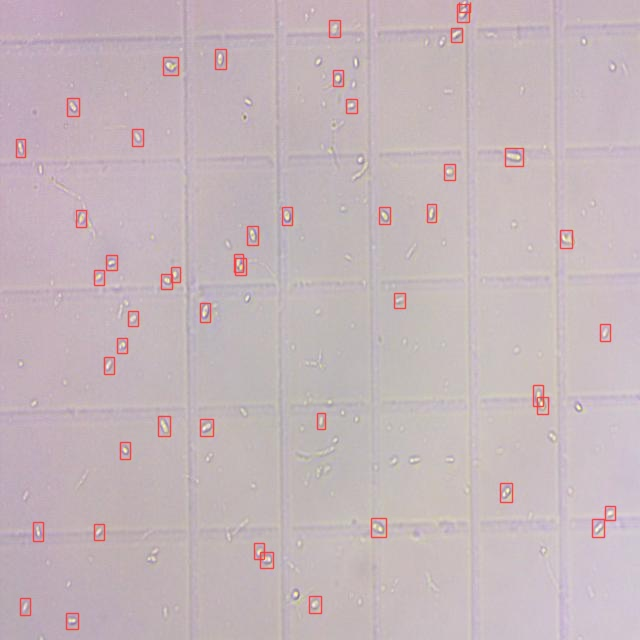

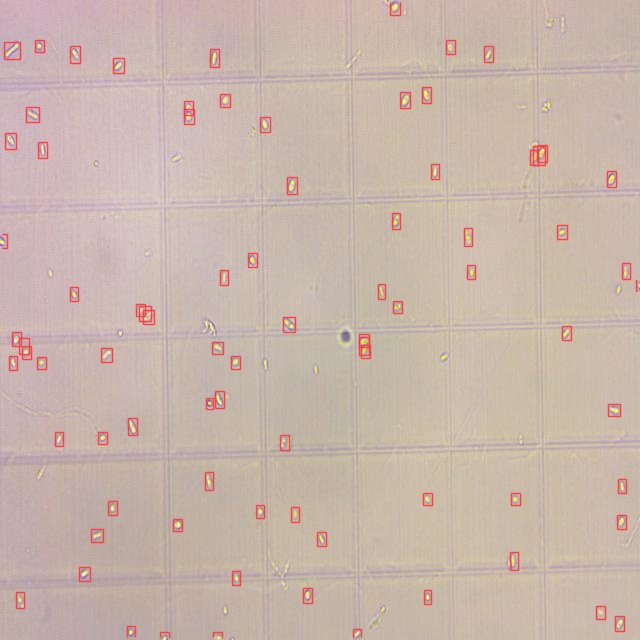

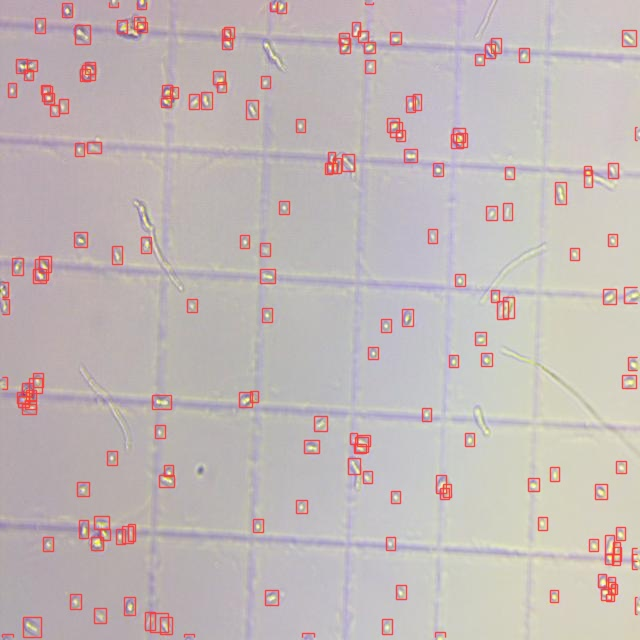

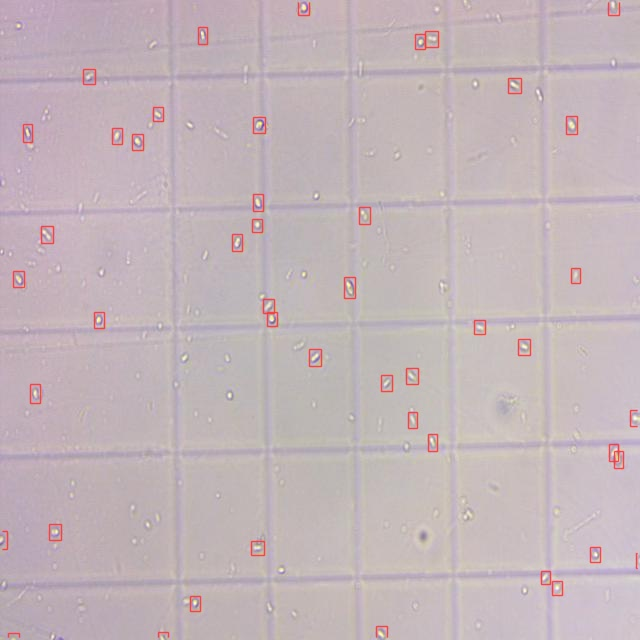

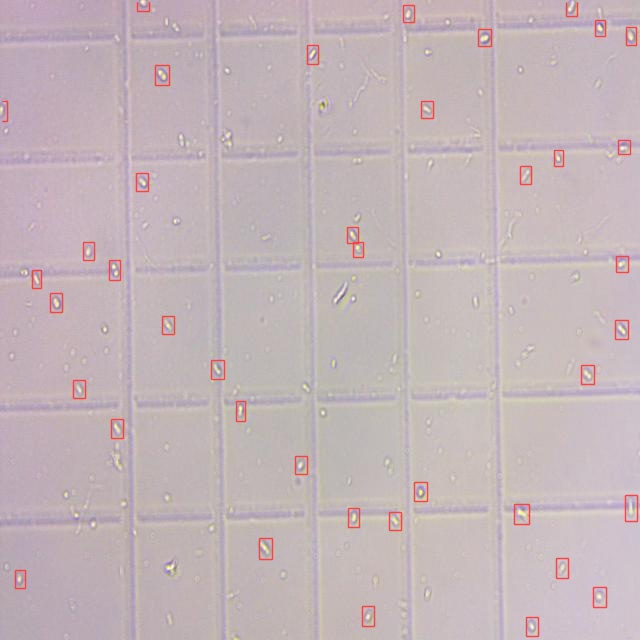

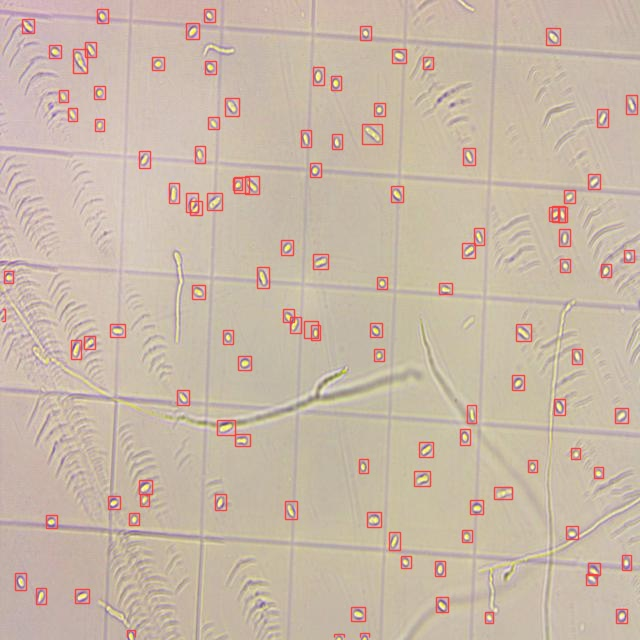

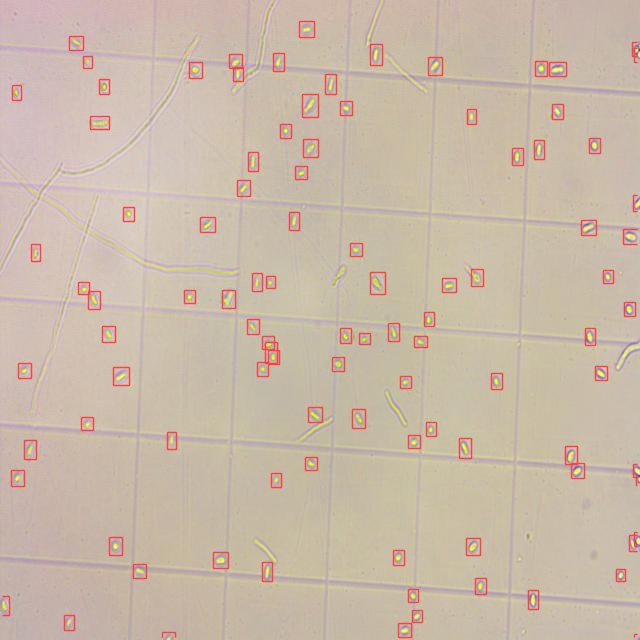

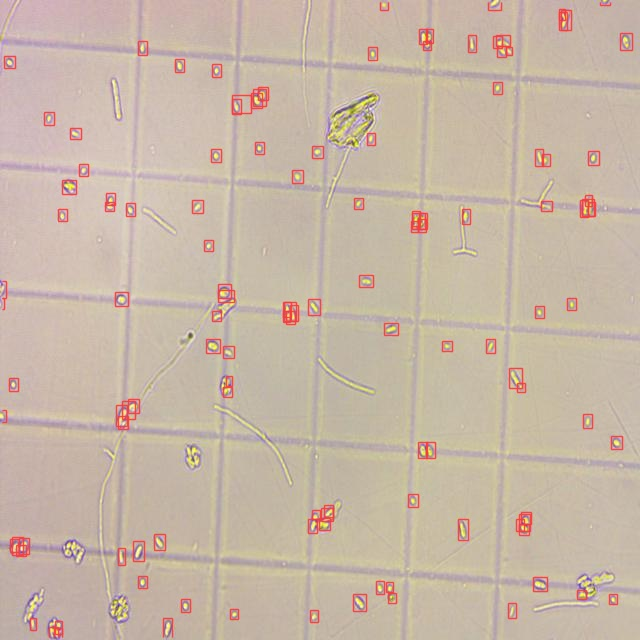

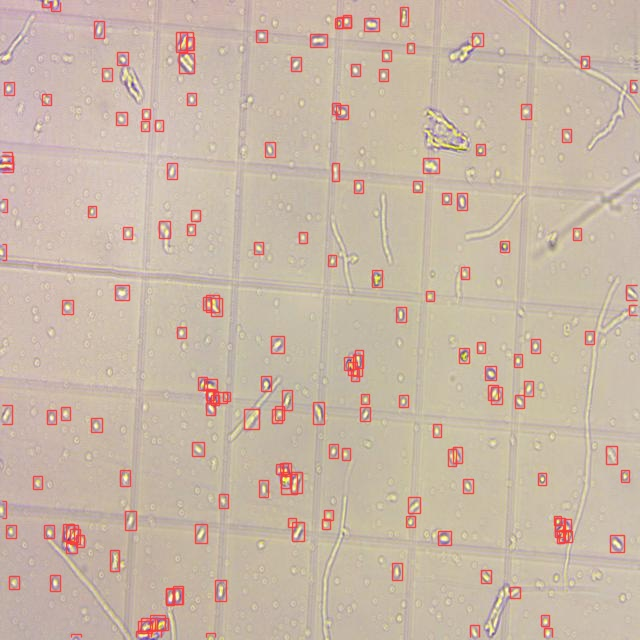

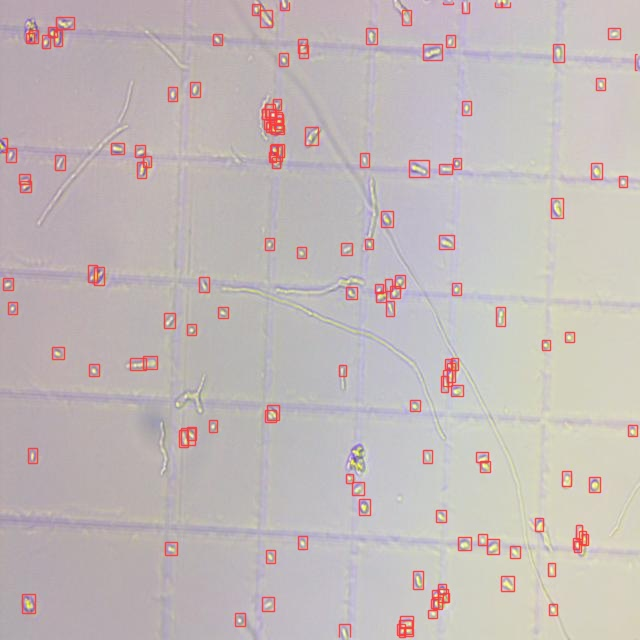

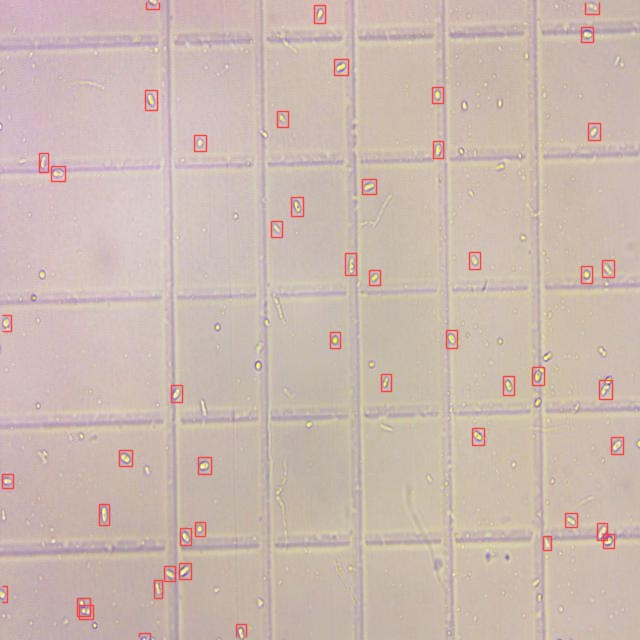

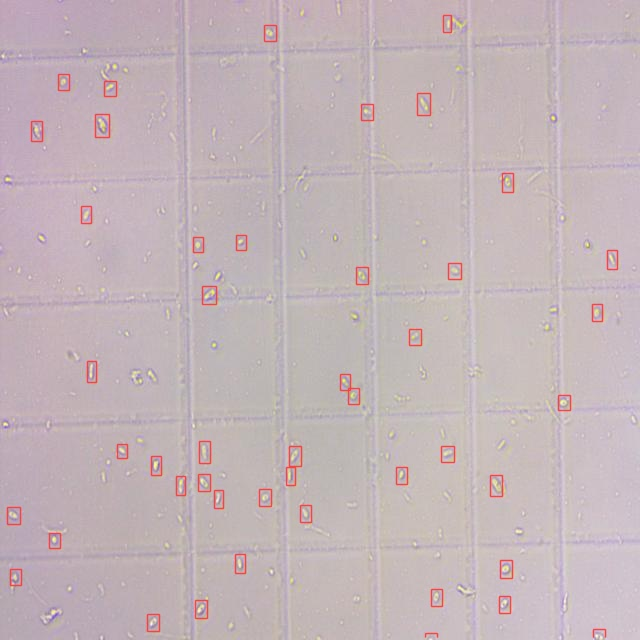

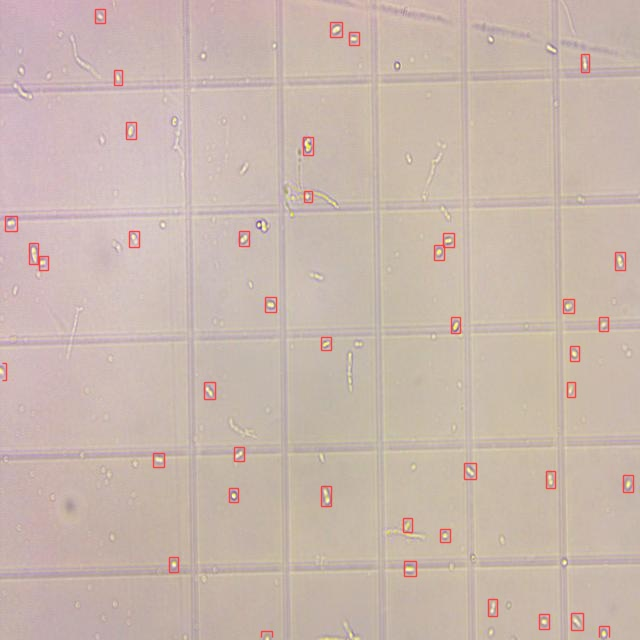

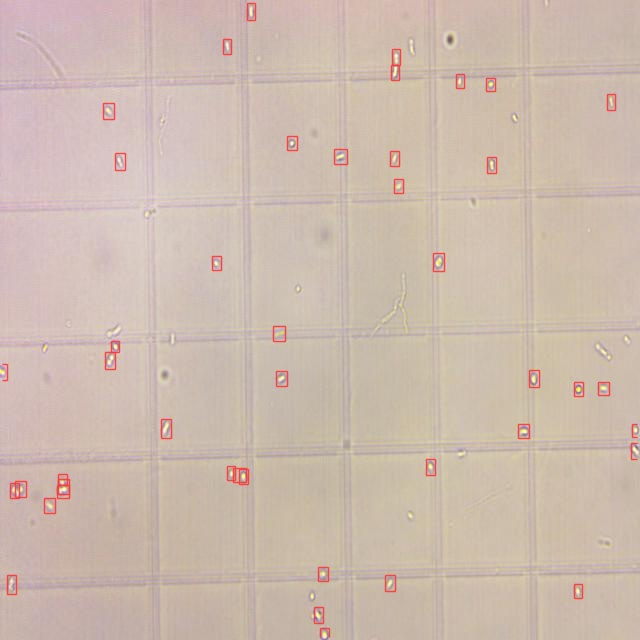

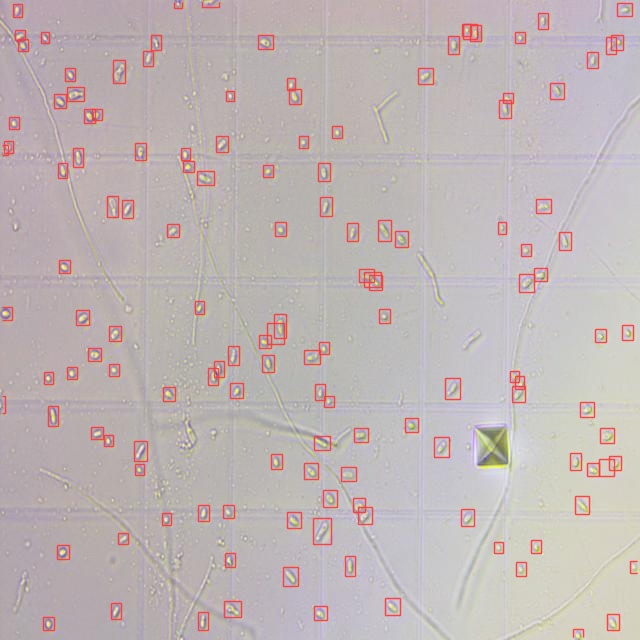

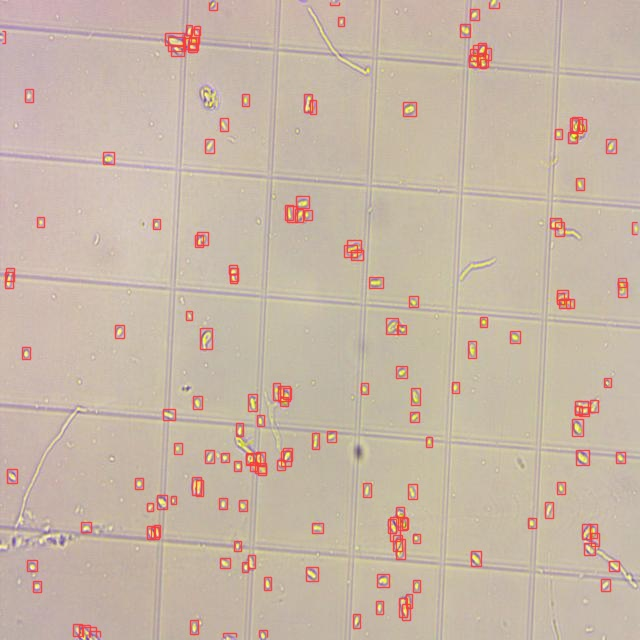

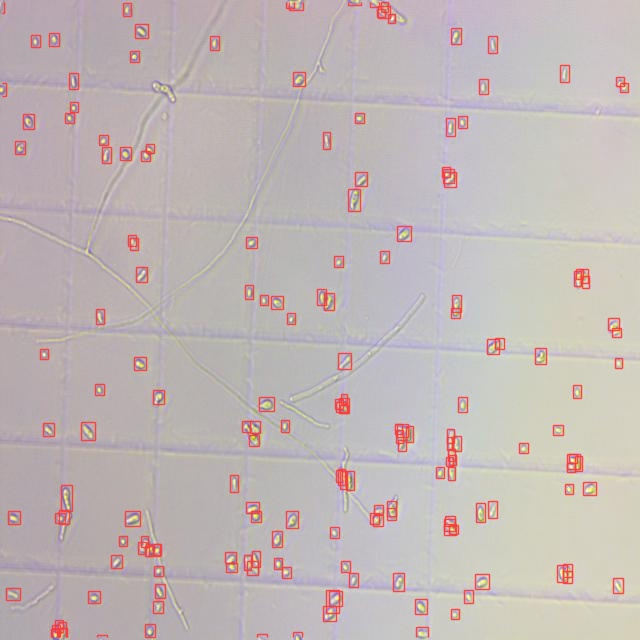

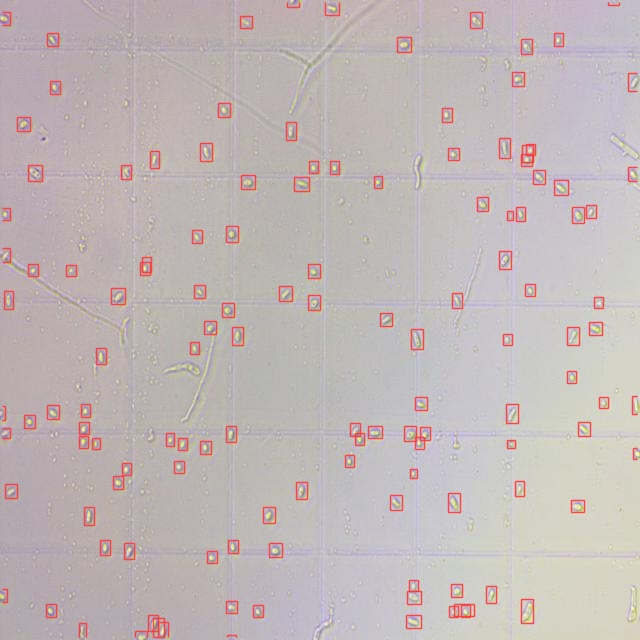

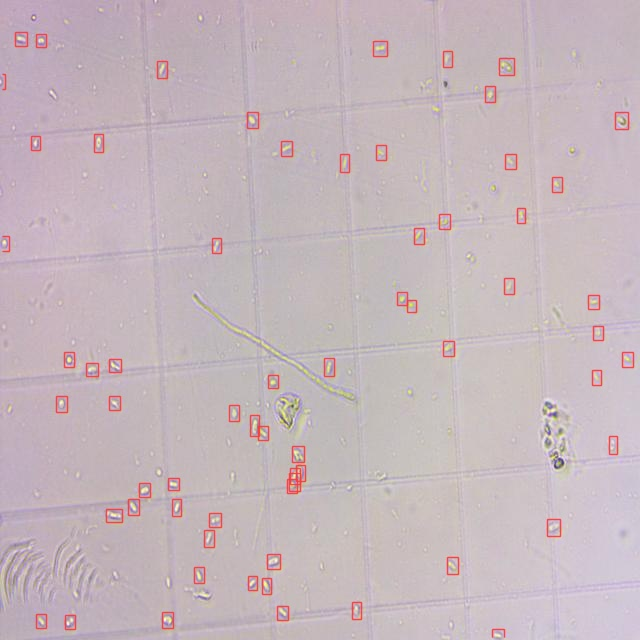

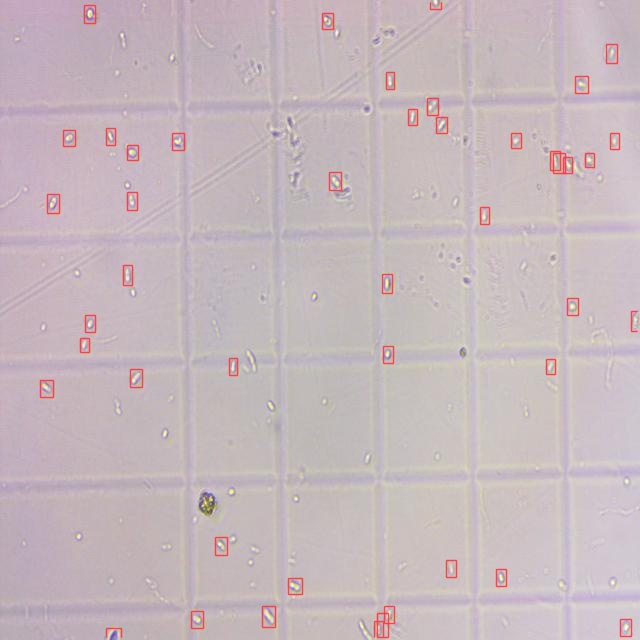

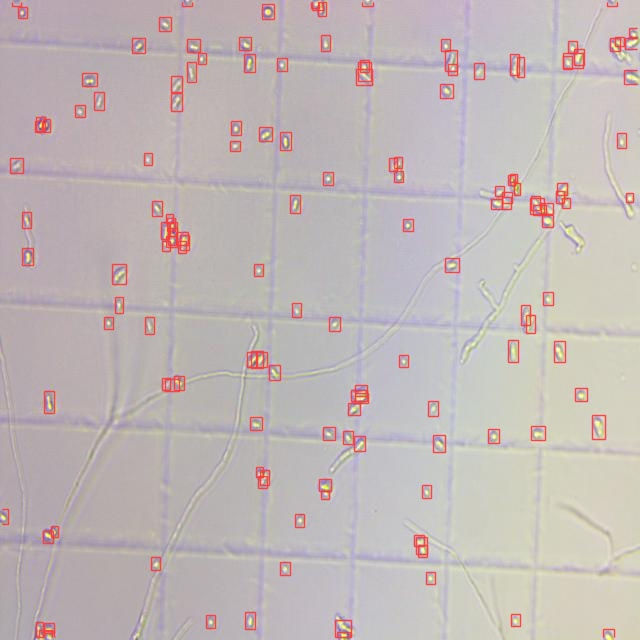

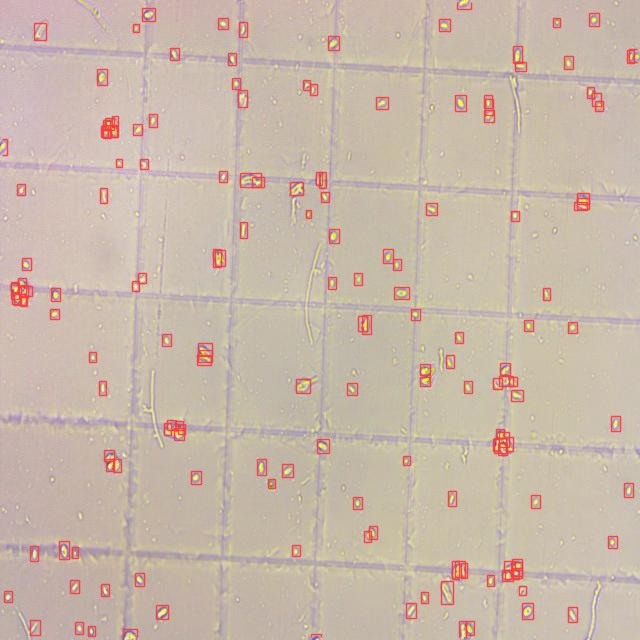

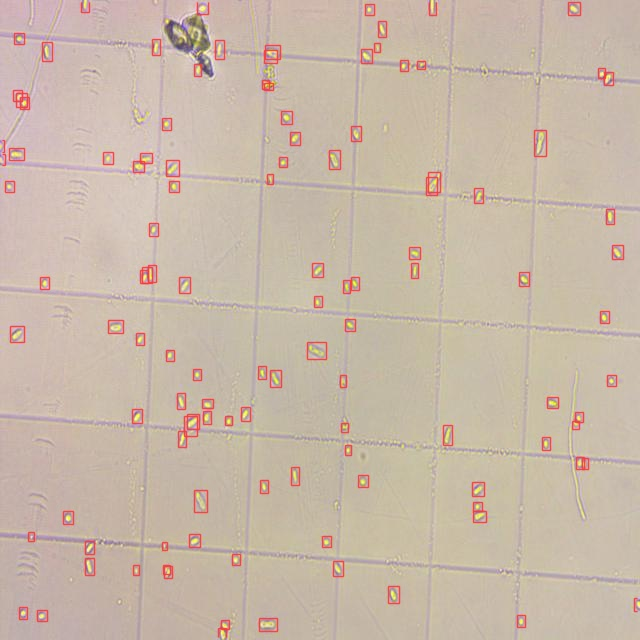

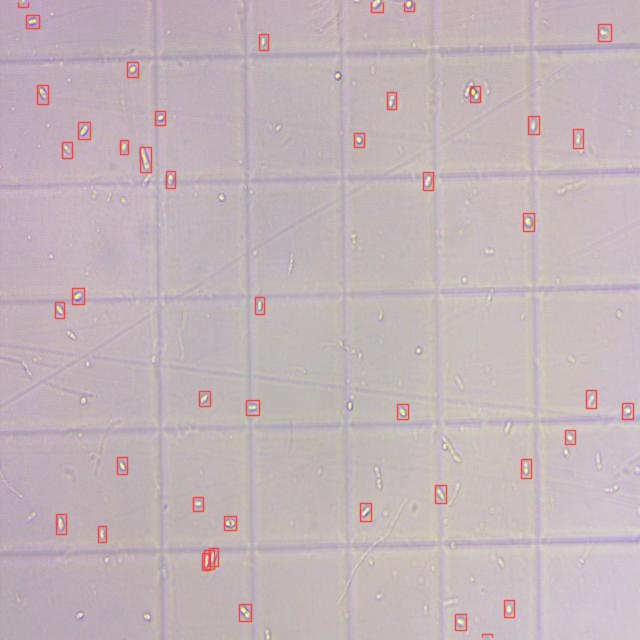

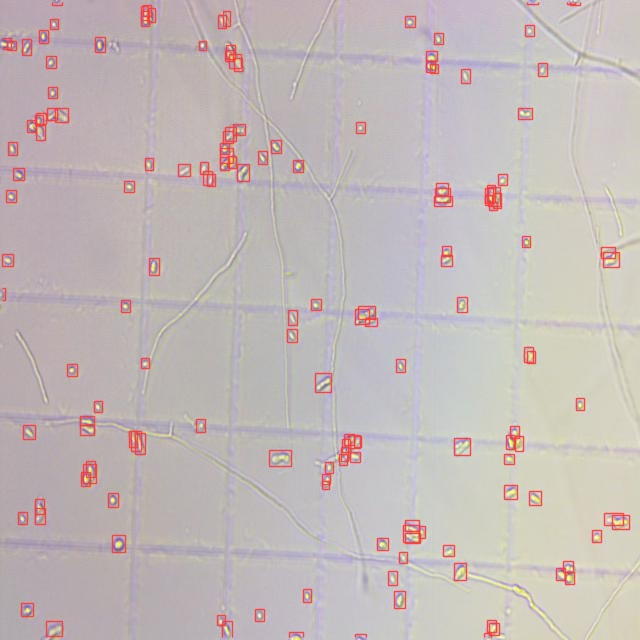

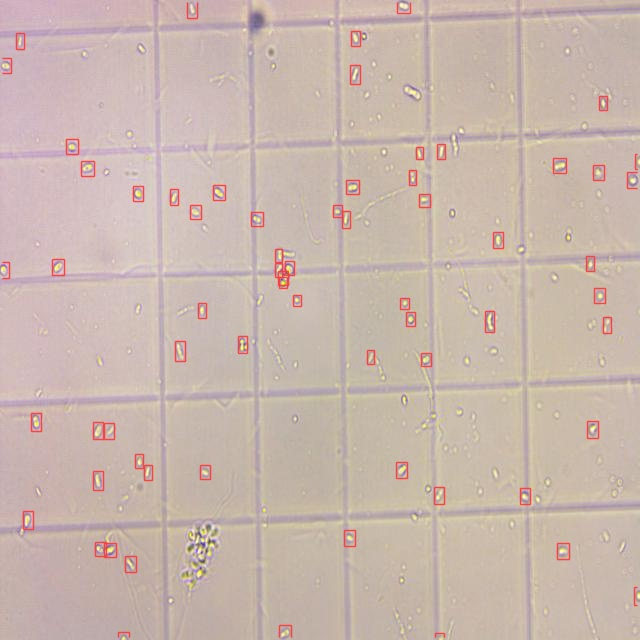

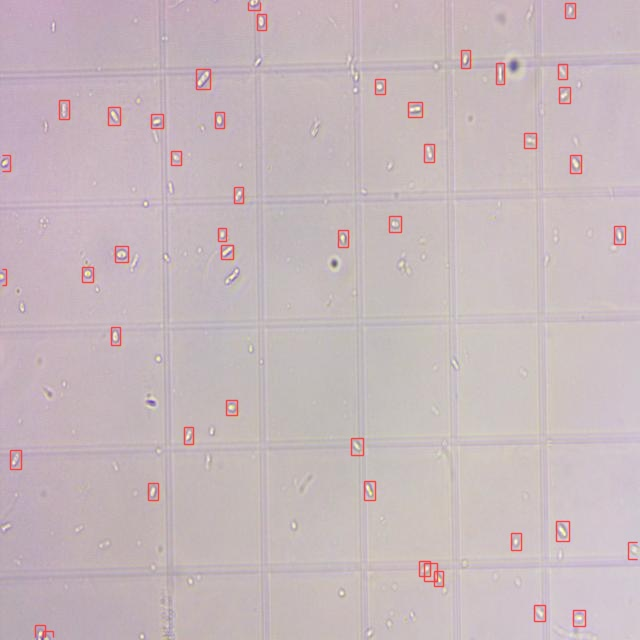

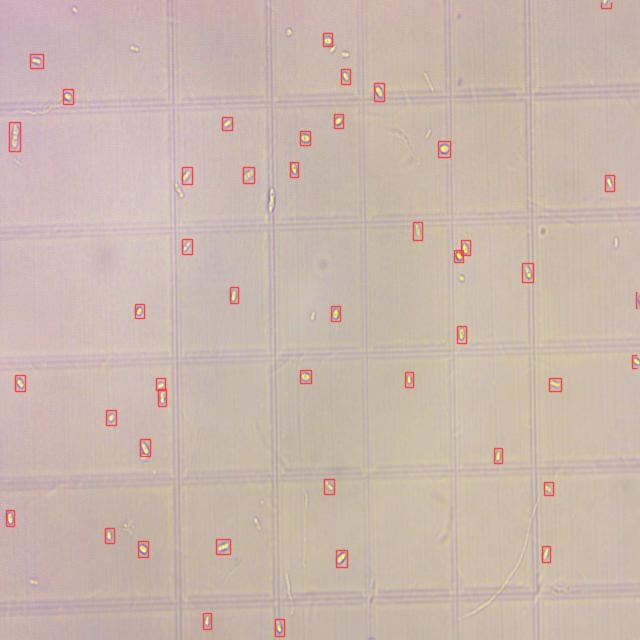

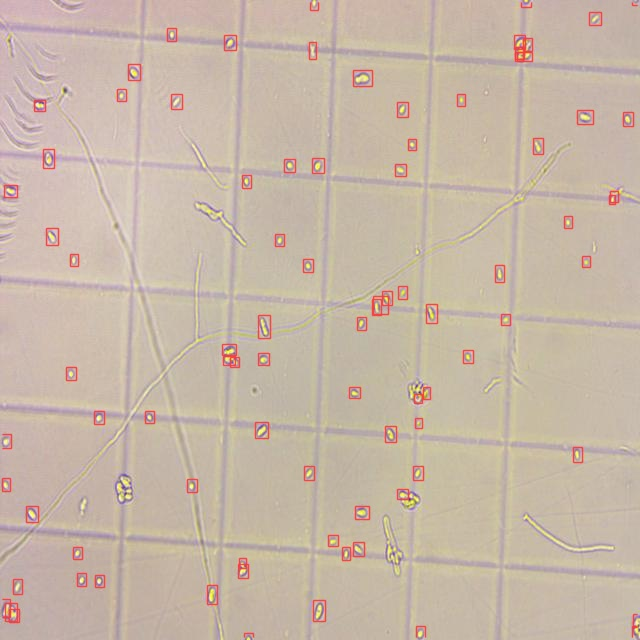

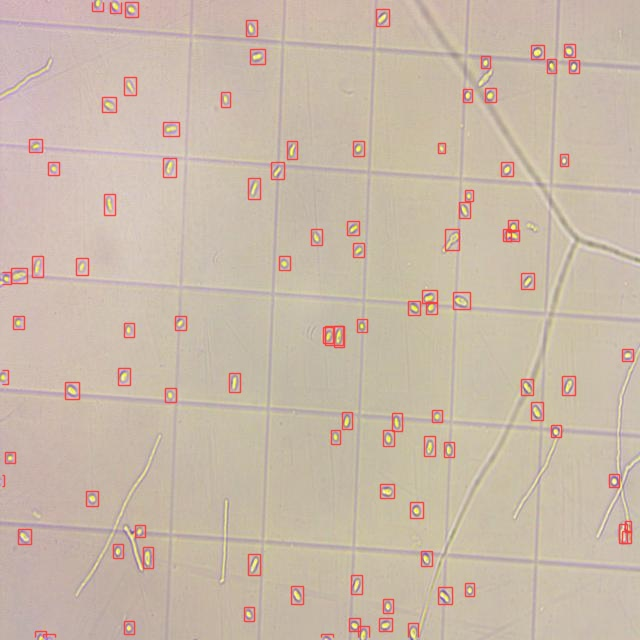

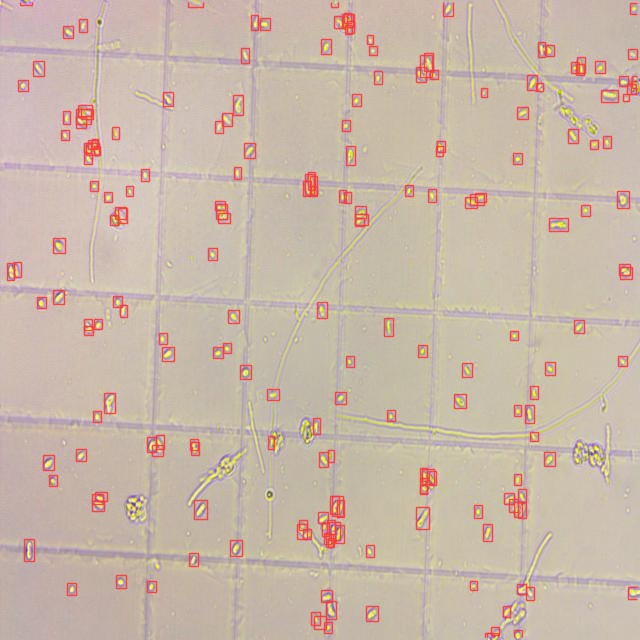

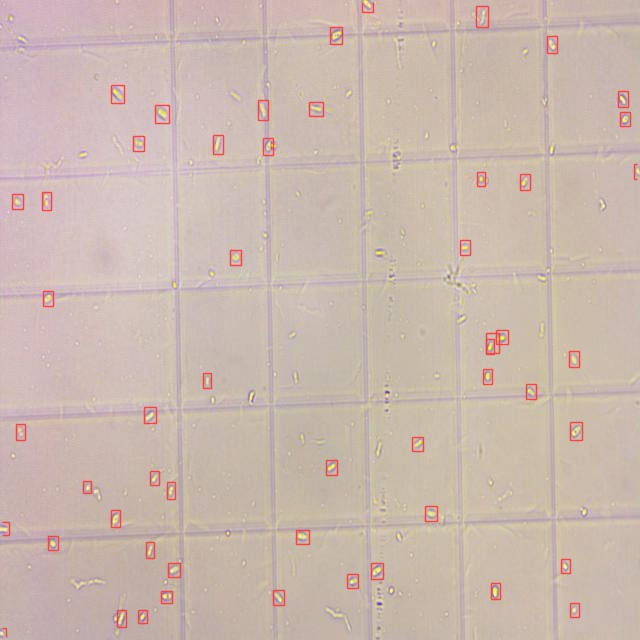

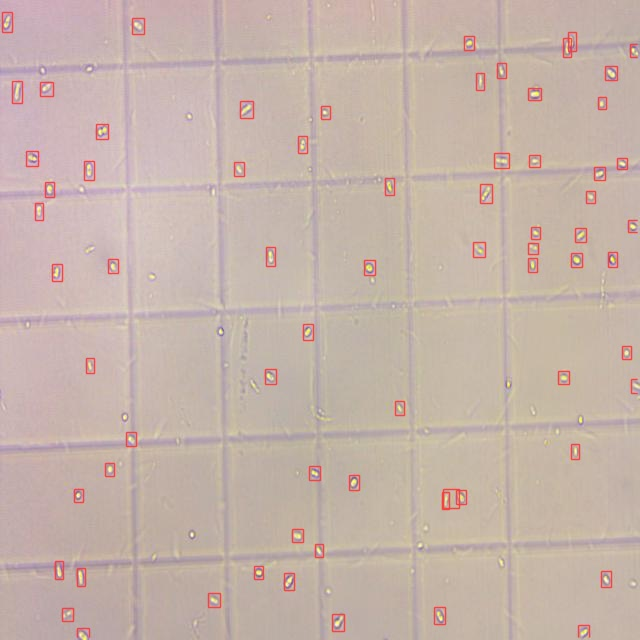

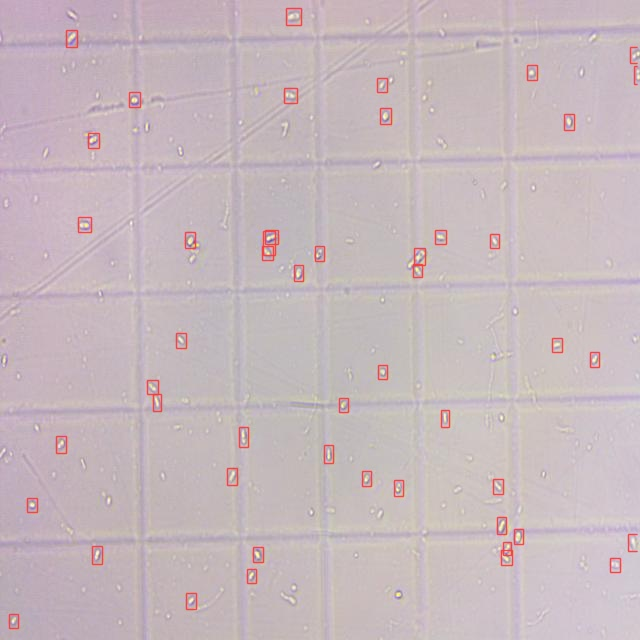

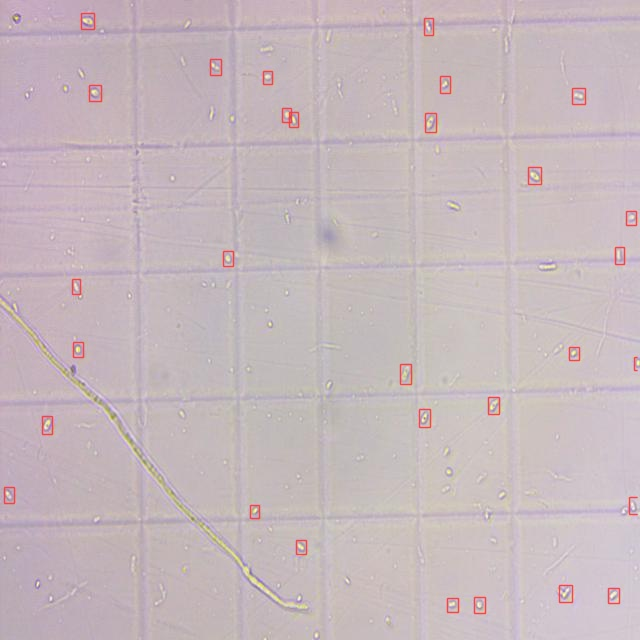

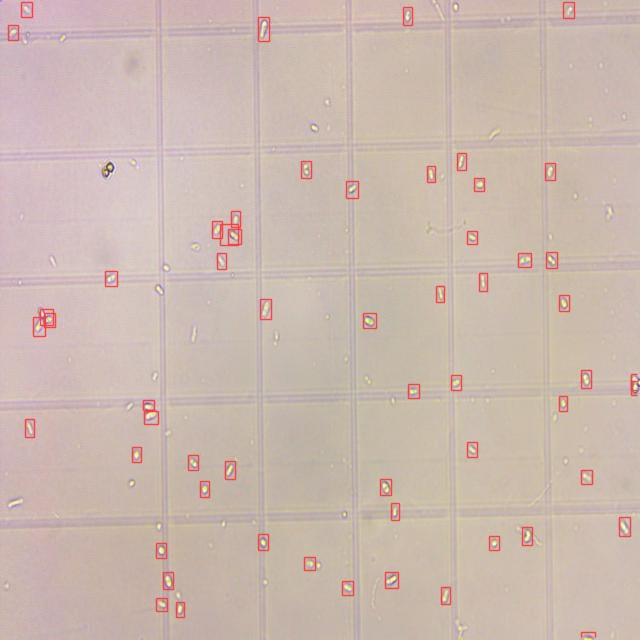

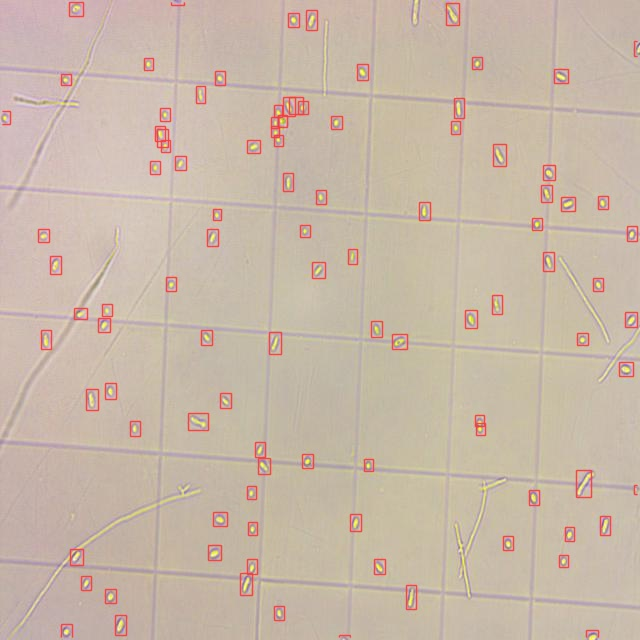

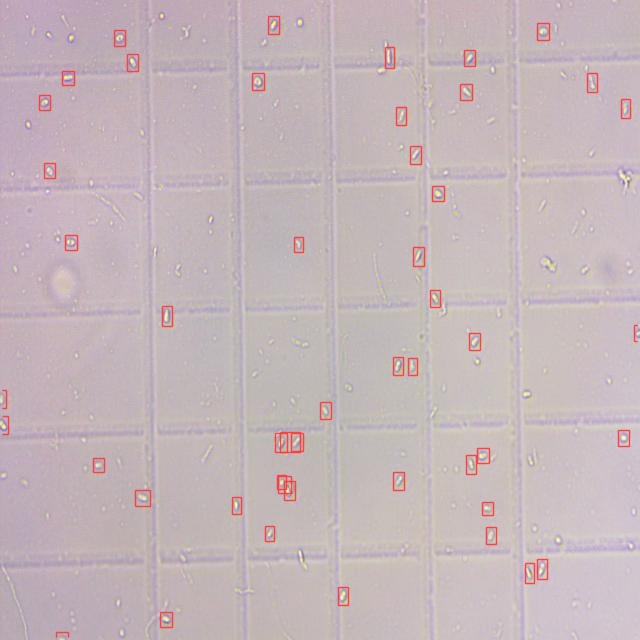

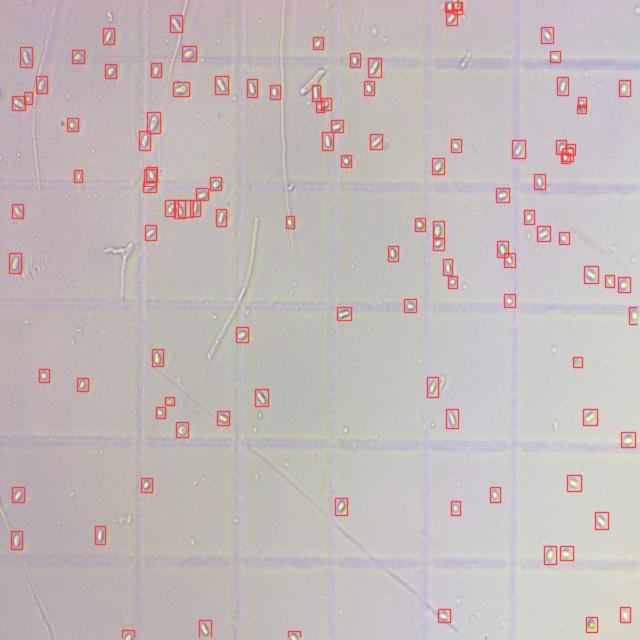

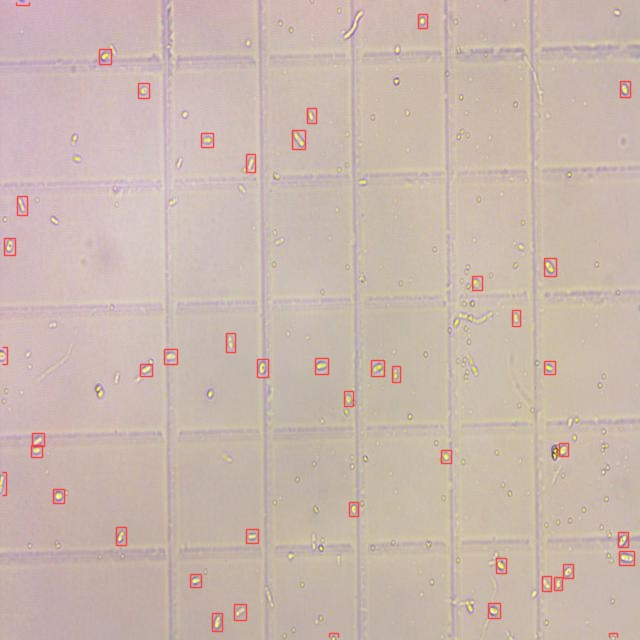

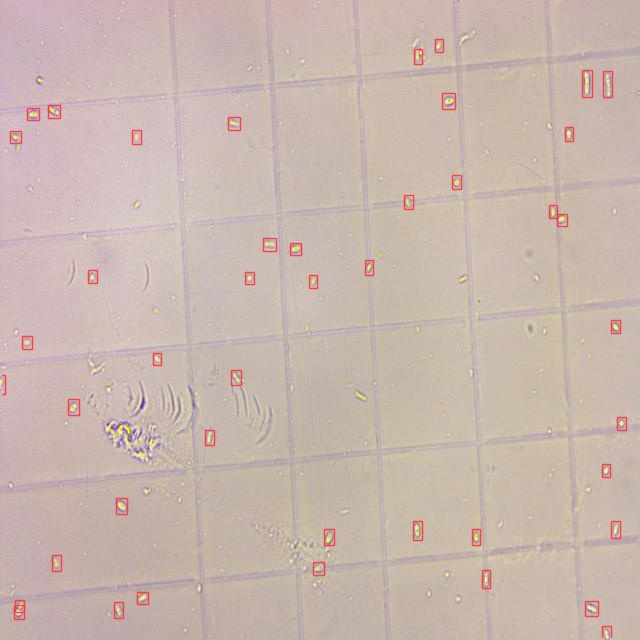

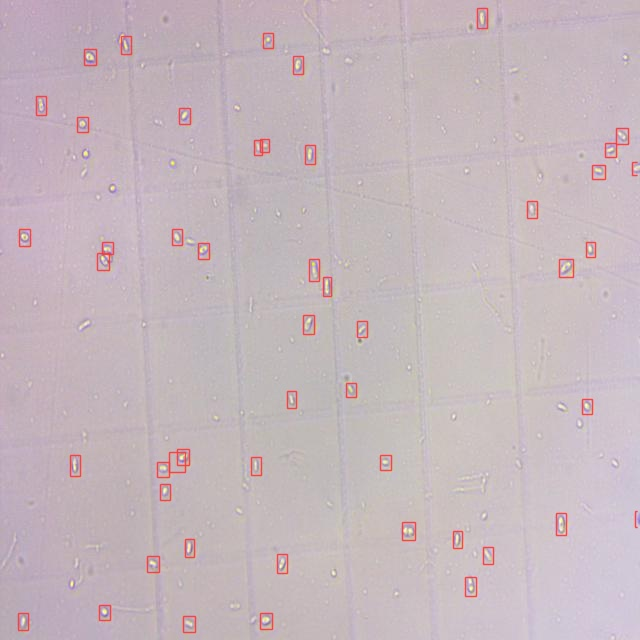

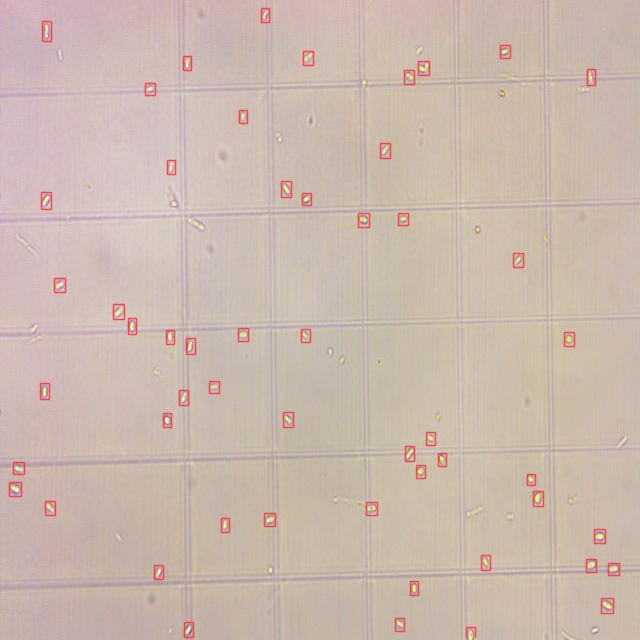

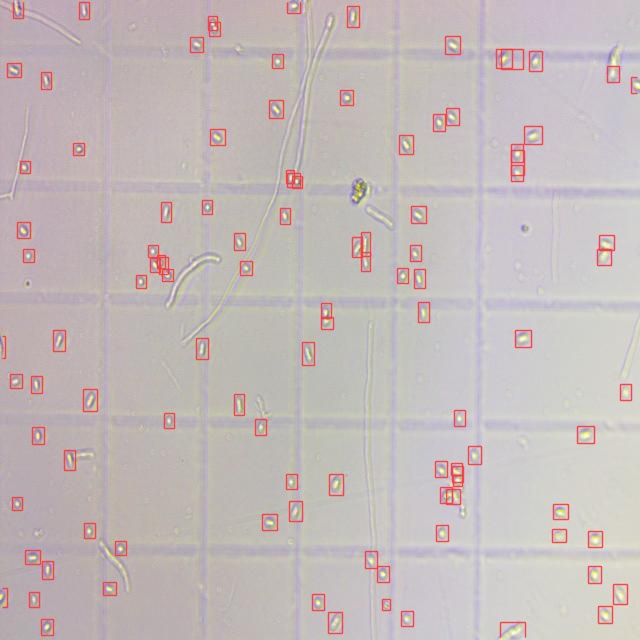

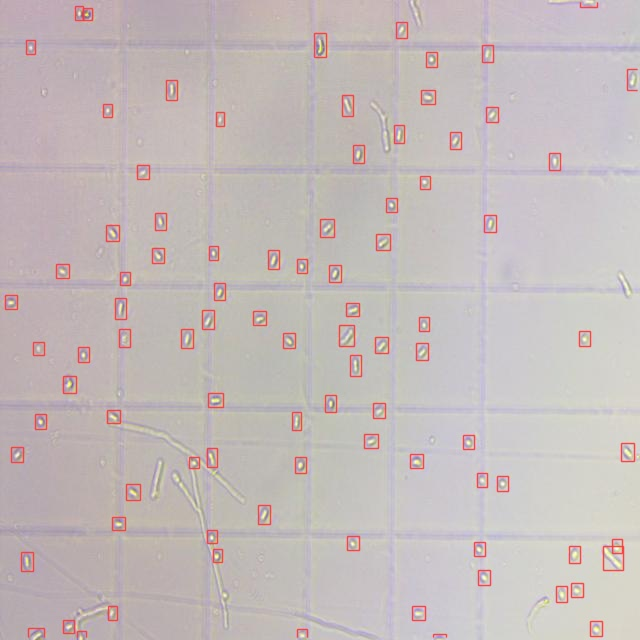

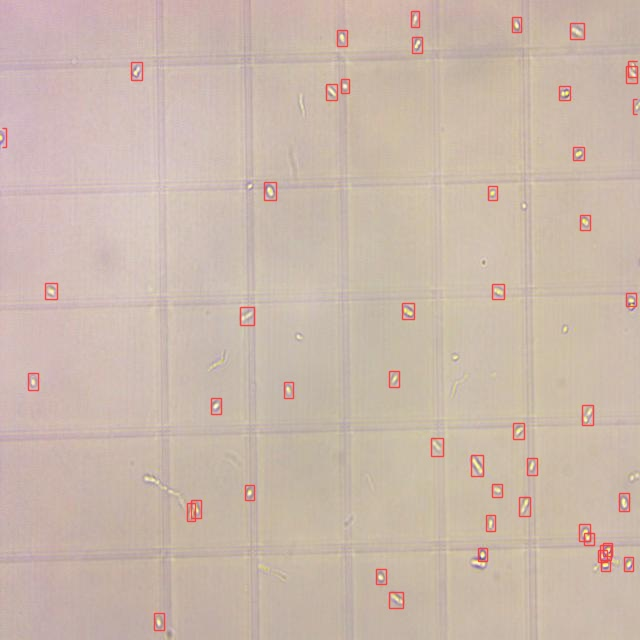

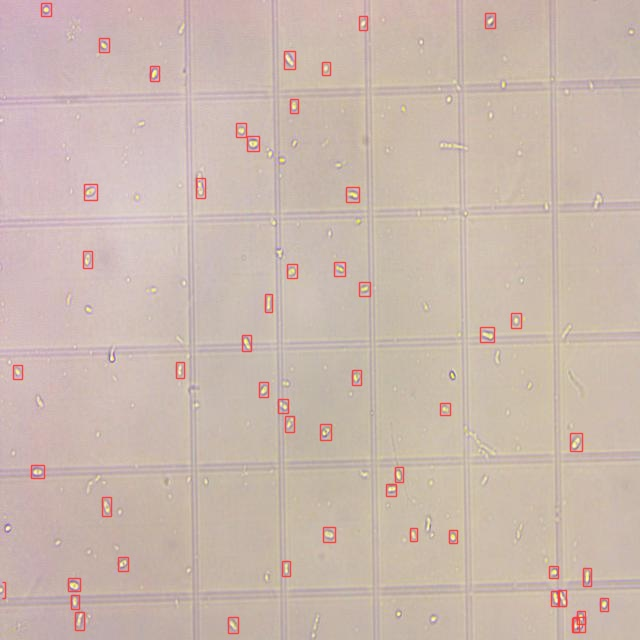

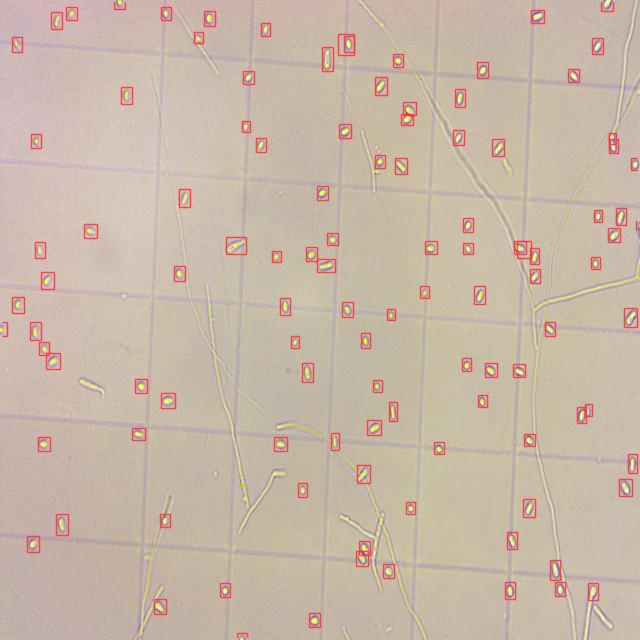

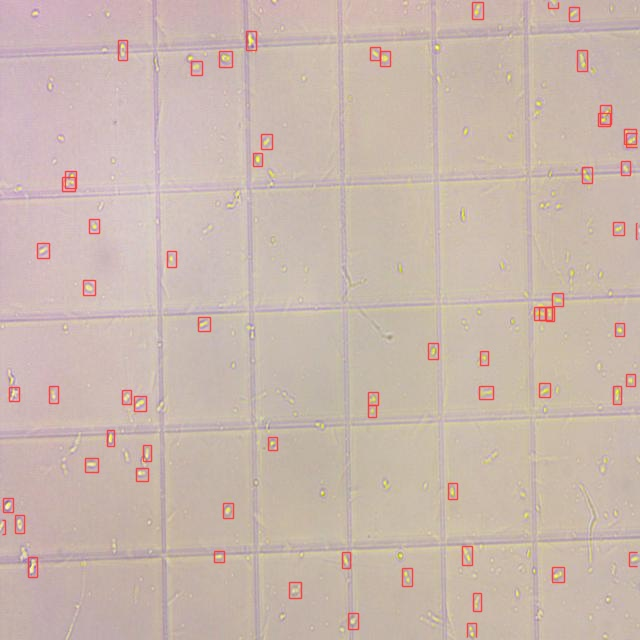

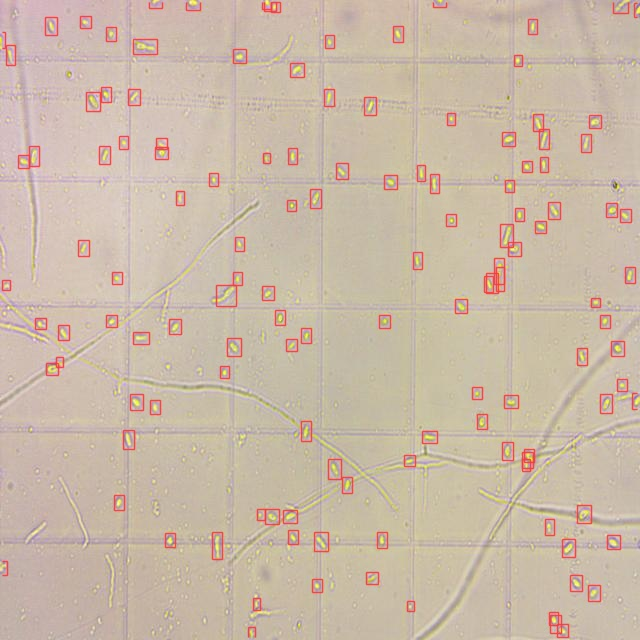

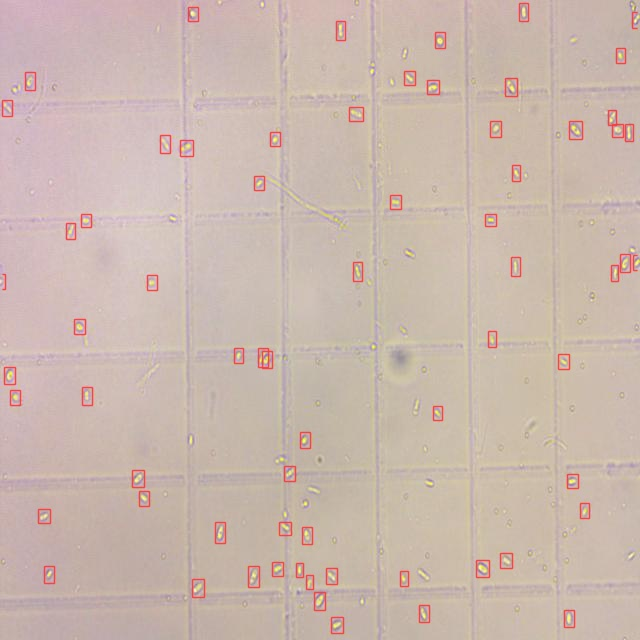

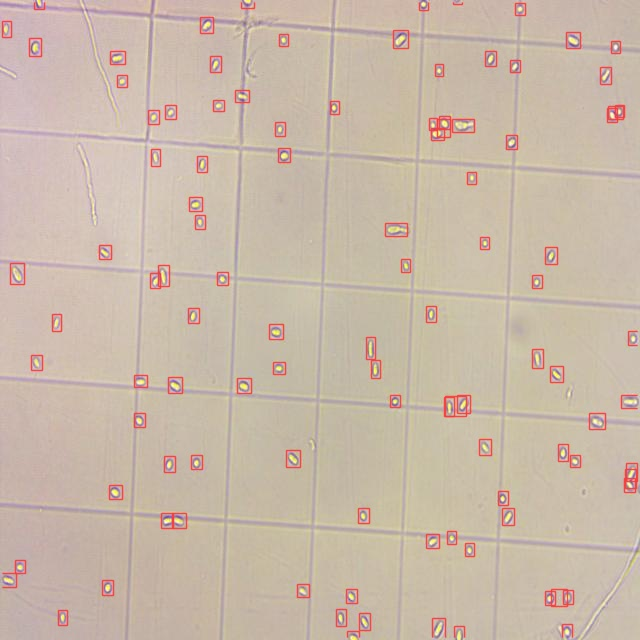

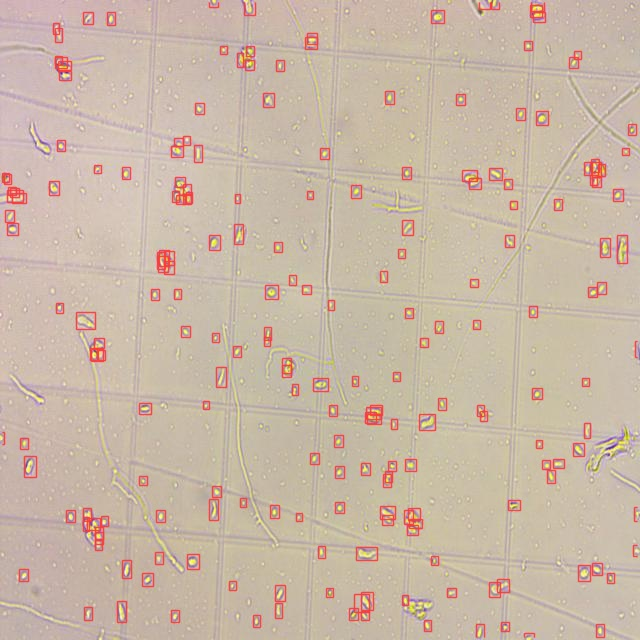

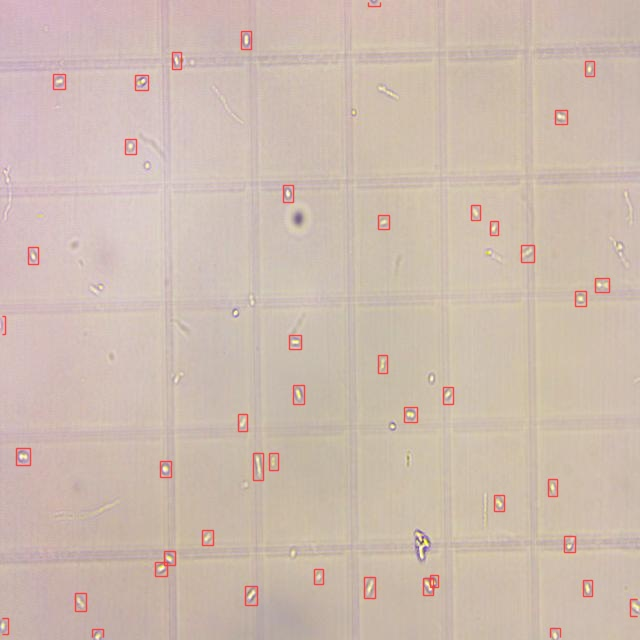

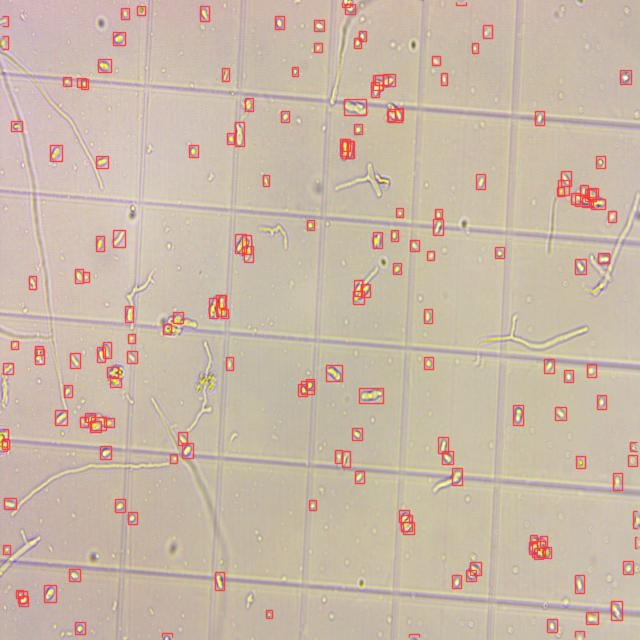

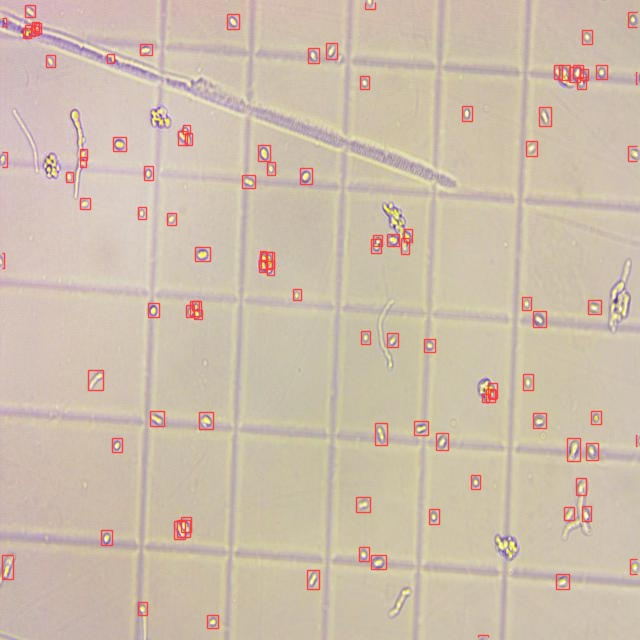

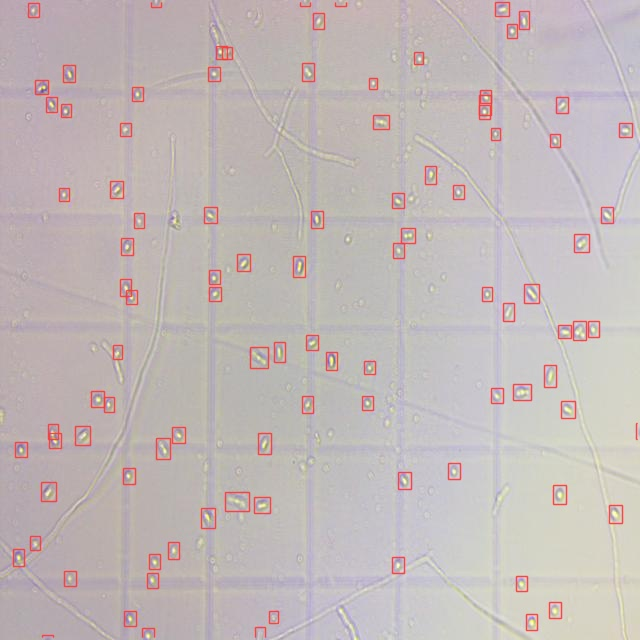

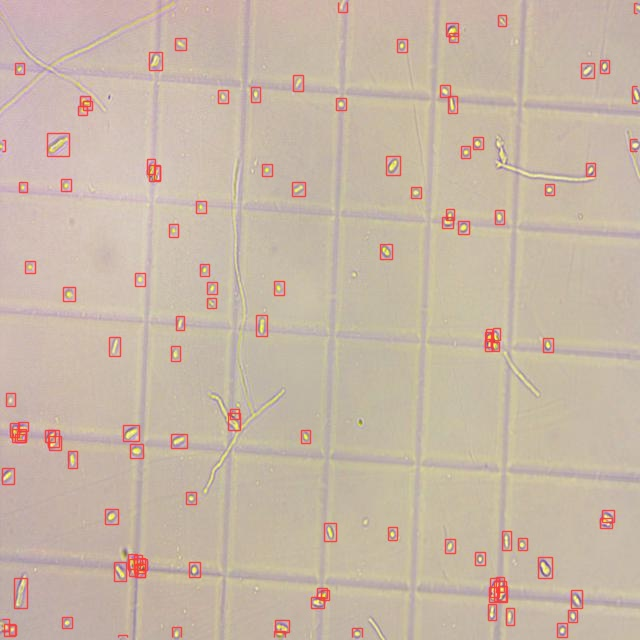

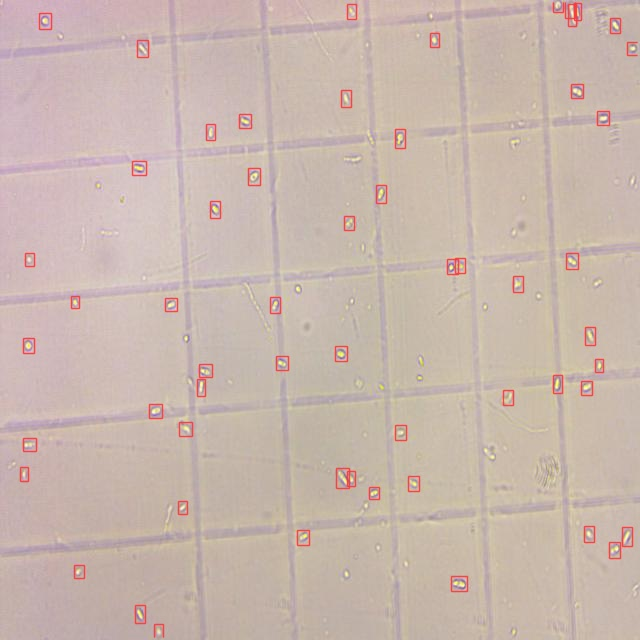

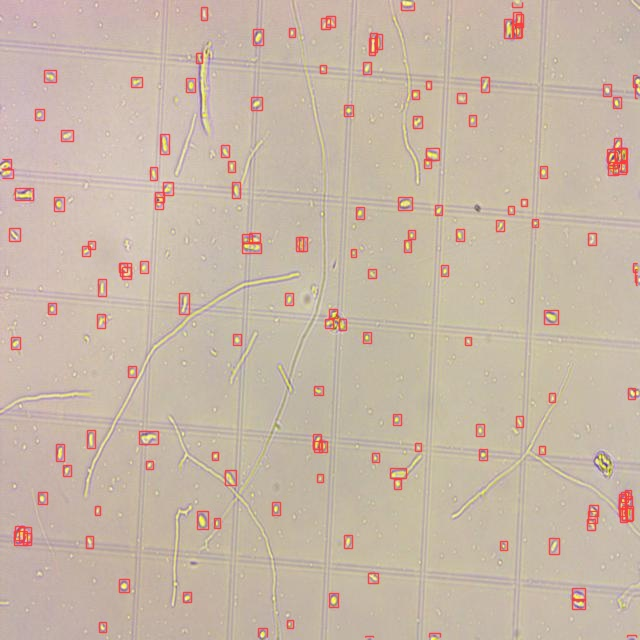

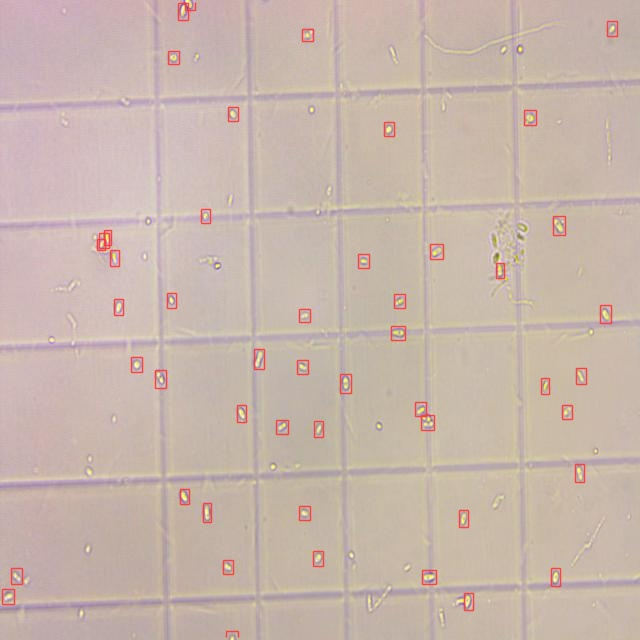

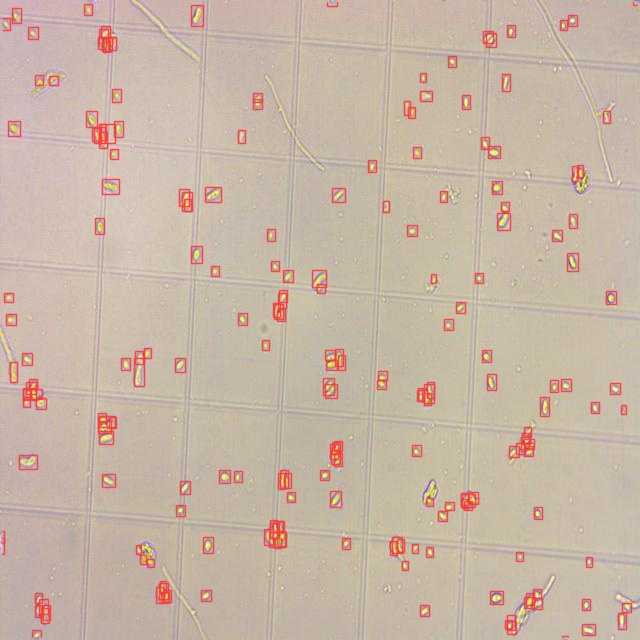

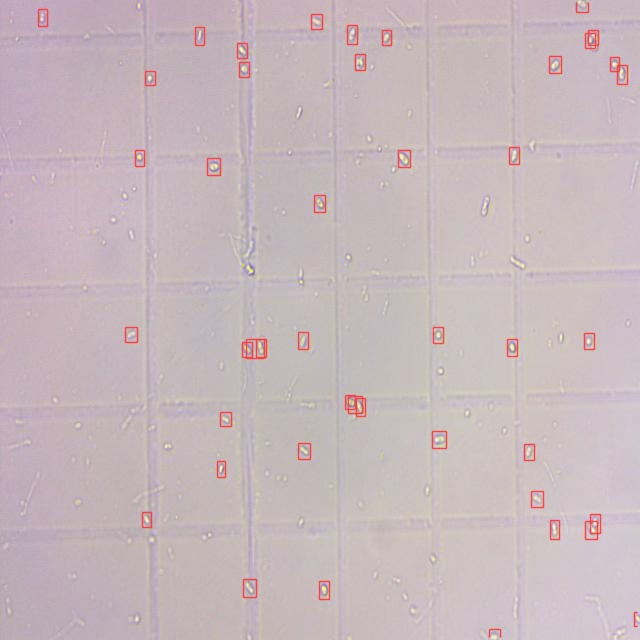

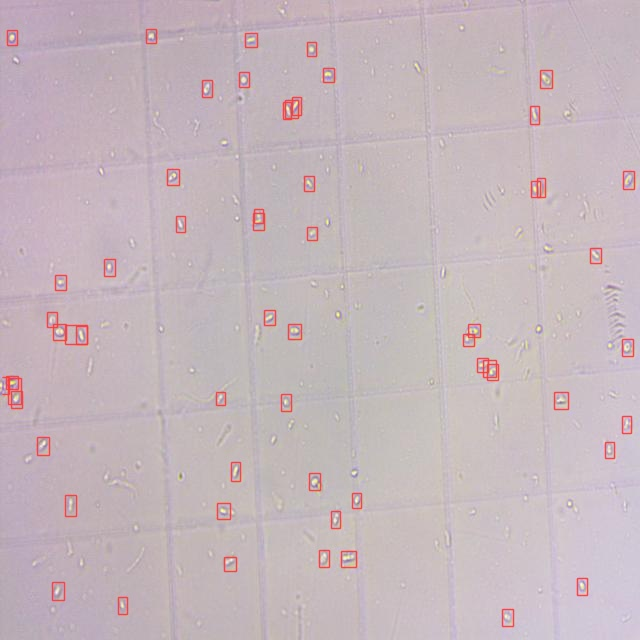

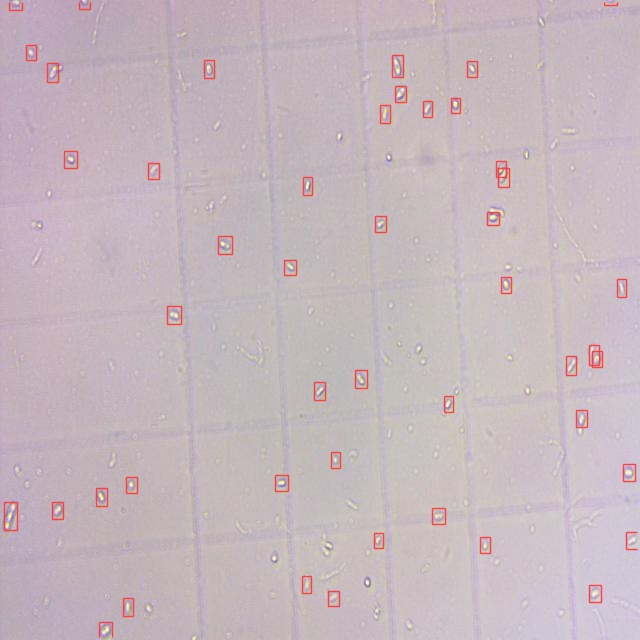

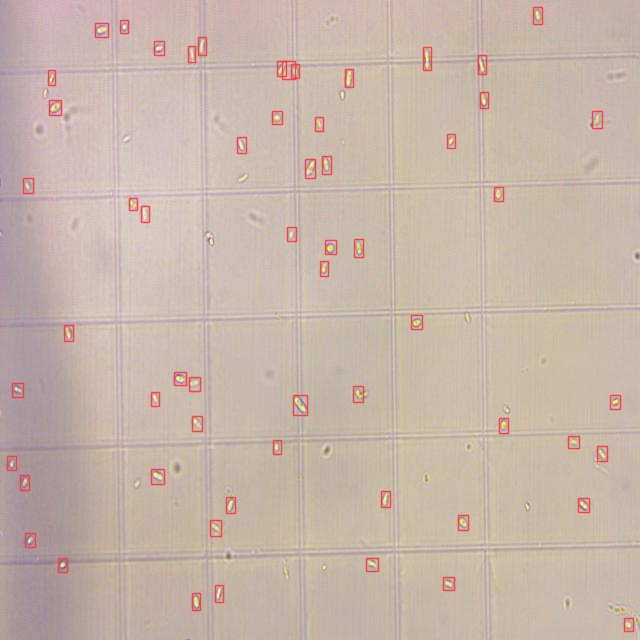

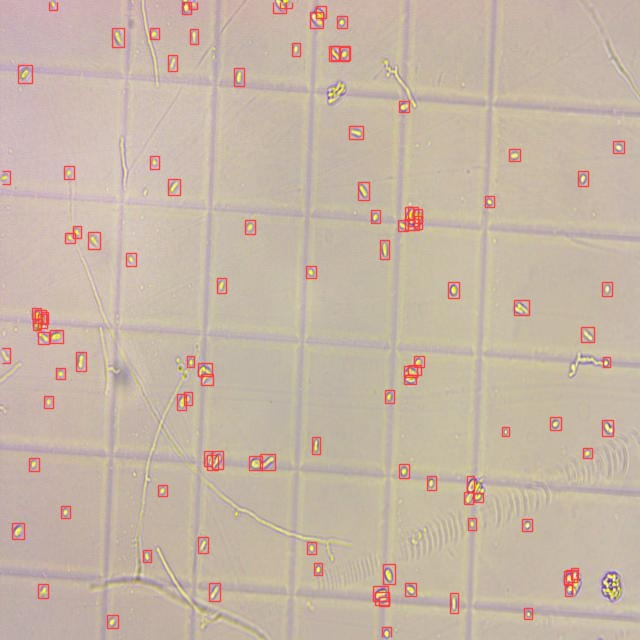

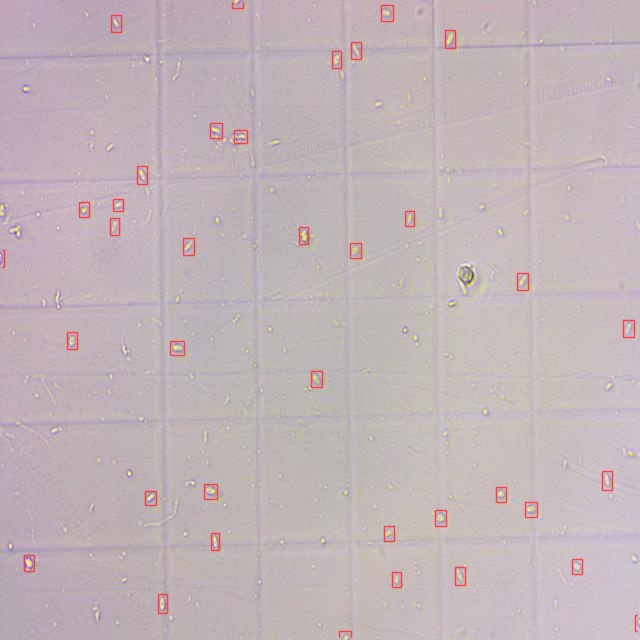

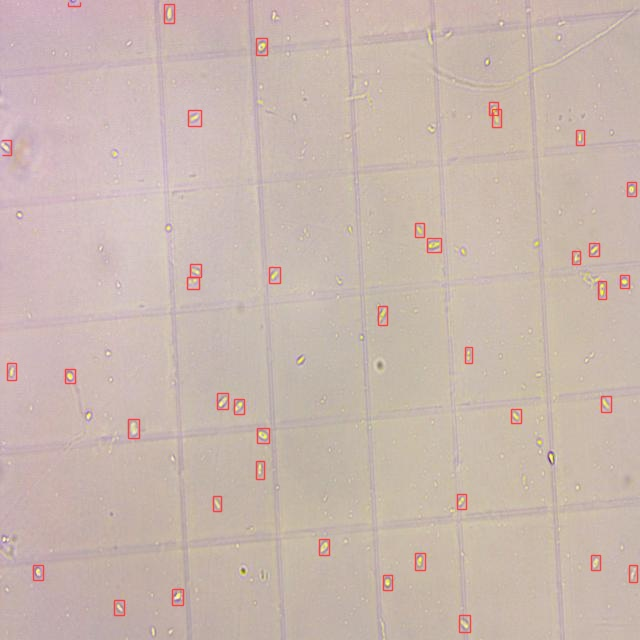

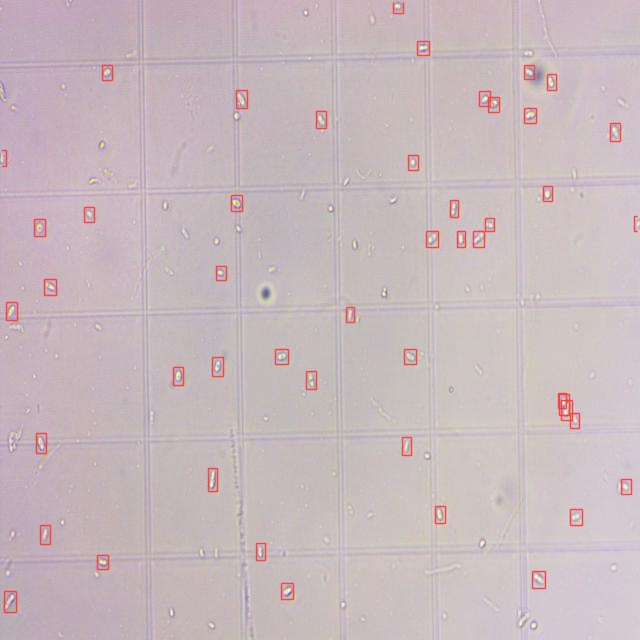

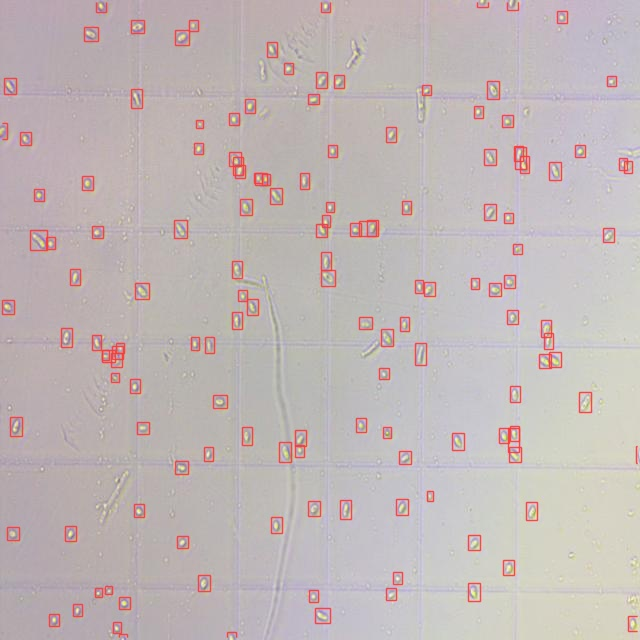

In [8]:
# вывод инференса всех тестовых изображений
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Conclusion and Next Steps

Congratulations! You've trained a custom YOLOv5 model to recognize your custom objects.

To improve you model's performance, we recommend first interating on your datasets coverage and quality. See this guide for [model performance improvement](https://github.com/ultralytics/yolov5/wiki/Tips-for-Best-Training-Results).

To deploy your model to an application, see this guide on [exporting your model to deployment destinations](https://github.com/ultralytics/yolov5/issues/251).

Once your model is in production, you will want to continually iterate and improve on your dataset and model via [active learning](https://blog.roboflow.com/what-is-active-learning/).

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

# Step 6: Calculate average numb blastospores

In [9]:
# Выбор пути к txt файлам с предсказанными координатами bounding boxes
#path_to_pred_lbls = '/content/drive/MyDrive/Misha/YOLO5/results/predict_labels'
path_to_pred_lbls = '/content/yolov5/runs/detect/exp/labels'

all_lbls_pathes = sorted(glob.glob(os.path.join(path_to_pred_lbls, '*.txt')))
blasto_numb = {}
for filename in all_lbls_pathes:
     with open(filename, 'r') as txt_file:
         contents = txt_file.read()
         blasto_calc = len(contents.split('\n')[:-1])
         blasto_numb[filename.split('/')[-1]] = blasto_calc
print(f'Среднее число предсказанных бластоспор: {np.round(np.mean(list(blasto_numb.values())), 0)}')

Среднее число предсказанных бластоспор: 91.0


# Addition step: Time estimate to make predict on CPU

In [ ]:
!python detect.py --weights /content/drive/MyDrive/Misha/YOLO5/results/model_weights/best.pt --img 640 --conf 0.1 --source /content/drive/MyDrive/Misha/YOLO5/dataset/images/test  --line-thickness 1 --hide-labels --save-txt

In [ ]:
path_to_pred_lbls = '/content/yolov5/yolov5/runs/detect/exp/labels'

all_lbls_pathes = sorted(glob.glob(os.path.join(path_to_pred_lbls, '*.txt')))
blasto_numb = {}
for filename in all_lbls_pathes:
     with open(filename, 'r') as txt_file:
         contents = txt_file.read()
         blasto_calc = len(contents.split('\n')[:-1])
         blasto_numb[filename.split('/')[-1]] = blasto_calc
#print(blasto_numb)
print(f'Среднее число предсказанных бластоспор: {np.round(np.mean(list(blasto_numb.values())), 0)}')